# Assignment - 07
## CNN - Indian Food Classification

## Nakul Ramesh Varma - 21BDA35

### Question 3

#### Importing modules

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt  
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#### Initialising path and train - valadity dataset

In [2]:
IMG_SIZE = (256, 256)
VALID_SPLIT = 0.3
BATCH_SIZE = 32
SEED = 42
PATH = "./Food Classification"

# Get train image with generator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="training",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

# Get validation image with generator
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    PATH,
    validation_split=VALID_SPLIT,
    subset="validation",
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="categorical"
)

Found 6269 files belonging to 20 classes.
Using 4389 files for training.
Found 6269 files belonging to 20 classes.
Using 1880 files for validation.


In [3]:
classes = train_ds.class_names

#### Sample of the dataset

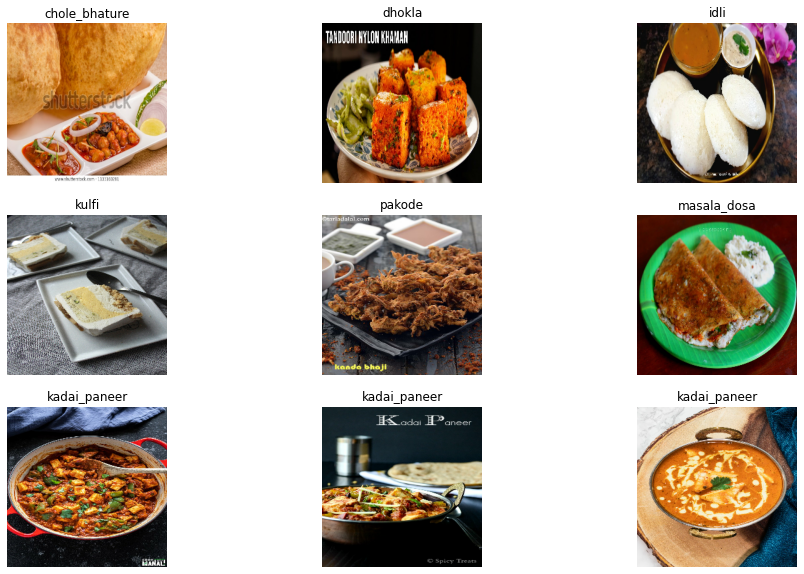

In [4]:
plt.figure(figsize=(16, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(classes[np.argmax(labels[i])])
        plt.axis("off")

#### Data augmentation: kind of transformations

In [5]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal"),
    layers.experimental.preprocessing.RandomRotation(0.1),
])

# Apply transformation to train data
augmented_train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

In [6]:
augmented_train_ds = augmented_train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

#### Define Model

In [7]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(x)
    x = layers.Conv2D(64, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 512]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    
    return keras.Model(inputs, outputs)

print(IMG_SIZE + (3,))
model = make_model(input_shape=IMG_SIZE + (3,), num_classes=len(classes))

(256, 256, 3)


#### Summary

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['sequential[0][0]']             
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['rescaling[0][0]']          

                                                                                                  
 activation_7 (Activation)      (None, 32, 32, 512)  0           ['batch_normalization_6[0][0]']  
                                                                                                  
 separable_conv2d_5 (SeparableC  (None, 32, 32, 512)  267264     ['activation_7[0][0]']           
 onv2D)                                                                                           
                                                                                                  
 batch_normalization_7 (BatchNo  (None, 32, 32, 512)  2048       ['separable_conv2d_5[0][0]']     
 rmalization)                                                                                     
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 16, 16, 512)  0          ['batch_normalization_7[0][0]']  
          

#### Training

In [10]:
ok = True

if ok:
    # Parameters
    EPOCHS = 10
    CALLBACK = [
        keras.callbacks.ModelCheckpoint(filepath='./model.{epoch:02d}-{val_loss:.2f}.h5'),
        keras.callbacks.EarlyStopping(patience=15)
    ]
    
    model.compile(
        optimizer='adam',
        loss="categorical_crossentropy",
        metrics=["categorical_accuracy"],
    )
    
    history = model.fit(
        augmented_train_ds,
        epochs=EPOCHS,
        callbacks=CALLBACK,
        validation_data=val_ds,
    )
    
else:
    model = keras.models.load_model('./indian-food-classification-keras-cnn/save_at_50.h5')

Epoch 1/10
138/138 [==============================] - 1118s 8s/step - loss: 1.4167 - categorical_accuracy: 0.5783 - val_loss: 2.6788 - val_categorical_accuracy: 0.3213
Epoch 2/10
138/138 [==============================] - 1093s 8s/step - loss: 1.3178 - categorical_accuracy: 0.5974 - val_loss: 3.0463 - val_categorical_accuracy: 0.3021
Epoch 3/10
138/138 [==============================] - 1065s 8s/step - loss: 1.2298 - categorical_accuracy: 0.6311 - val_loss: 2.7005 - val_categorical_accuracy: 0.3580
Epoch 4/10
138/138 [==============================] - 1008s 7s/step - loss: 1.1327 - categorical_accuracy: 0.6603 - val_loss: 2.7463 - val_categorical_accuracy: 0.3303
Epoch 5/10
138/138 [==============================] - 1050s 8s/step - loss: 1.0712 - categorical_accuracy: 0.6760 - val_loss: 2.5430 - val_categorical_accuracy: 0.4053
Epoch 6/10
138/138 [==============================] - 1063s 8s/step - loss: 0.9982 - categorical_accuracy: 0.7018 - val_loss: 2.1661 - val_categorical_accuracy:

In [11]:
print(history.history.keys())

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])


#### Accuracy and Loss vs Epoch graph

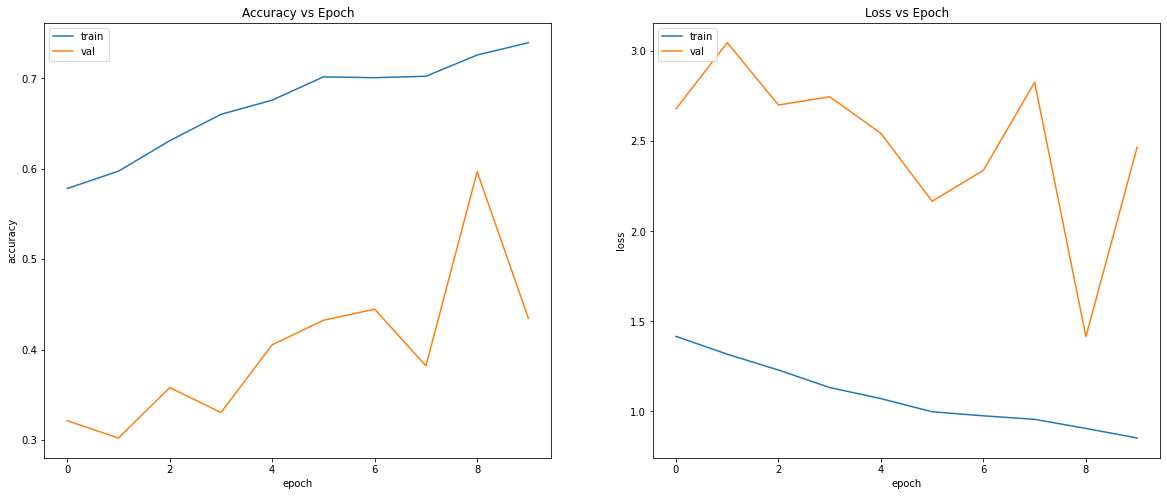

In [12]:
# Create a plot layout
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Summarize history for accuracy
ax[0].plot(history.history['categorical_accuracy'])
ax[0].plot(history.history['val_categorical_accuracy'])
ax[0].set_title('Accuracy vs Epoch')
ax[0].set(xlabel='epoch', ylabel='accuracy')
ax[0].legend(['train', 'val'], loc='upper left')

# Summarize history for loss
ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Loss vs Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
ax[1].legend(['train', 'val'], loc='upper left')

# Display plots
plt.show()

#### Testing on random images

1/1 [==============================] - 0s 60ms/step


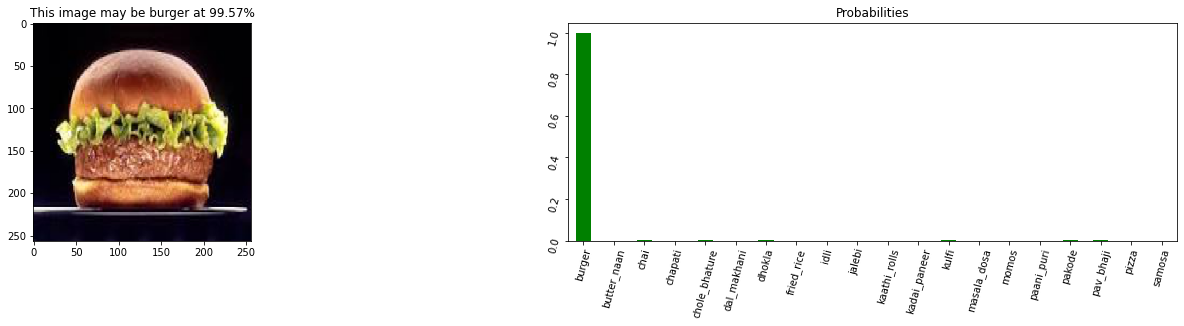

1/1 [==============================] - 0s 52ms/step


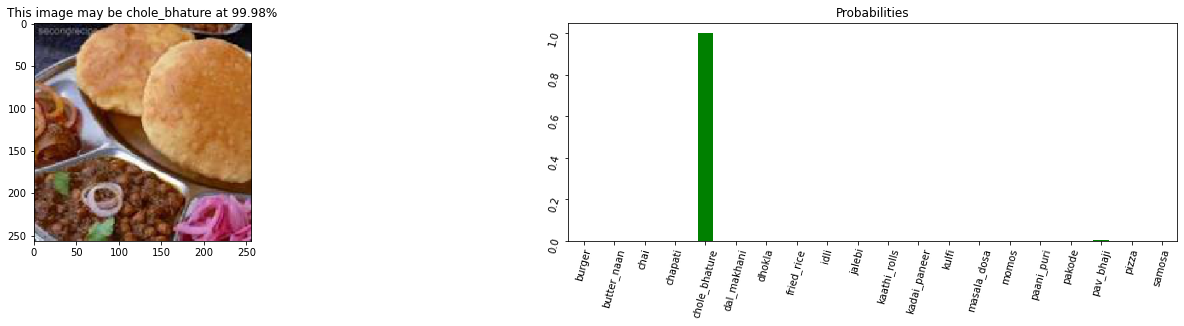

1/1 [==============================] - 0s 63ms/step


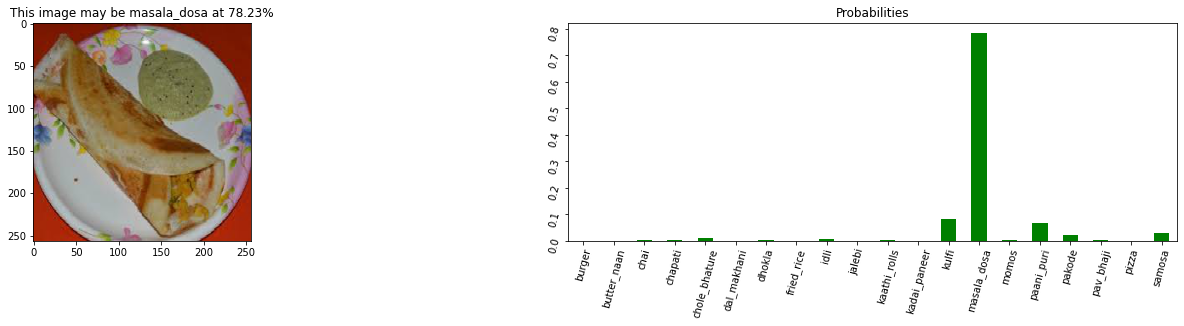

In [19]:
imgs = [
    "C:/Users/nakul/Downloads/download.jpg",
    "C:/Users/nakul/Downloads/download (1).jpg",
    "C:/Users/nakul/Downloads/images.jpg",
]

for img in imgs:
    try:
        # Load the image
        raw_img = keras.preprocessing.image.load_img(img, target_size=IMG_SIZE)
    except:
        continue
    
    # Conver to to numpy array
    img_array = keras.preprocessing.image.img_to_array(raw_img)
    
    # Reshaping
    img_array = tf.expand_dims(img_array, 0)  # Create batch axis
    
    # Make predictions
    predictions = model.predict(img_array)
    series      = pd.Series(predictions[0], index=classes)
    
    # Get score
    proba      = np.max(predictions)
    pred_class = classes[np.argmax(predictions)]
    
    # Display results
    fig, ax = plt.subplots(1, 2, figsize=(24, 4))
    
    ax[0].imshow(raw_img)
    ax[0].title.set_text(f"This image may be {pred_class} at {round(proba * 100,2)}%")
    
    series.plot(kind='bar', ax=ax[1], color='green')
    ax[1].title.set_text("Probabilities")
    ax[1].tick_params(labelrotation=75)
    
    plt.show()

Here the model performs quite well in predicting images from the internet. 

The model accuracy can be improved with more epochs but since it took more time I reduced it to 10